In [1]:
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import os
import math
import threading
import queue
import scipy


# Import data

Field Inventory Data

In [2]:
data = os.getcwd()+"/data/"
with open(data+"field_survey.geojson") as f:
    field_survey = gpd.read_file(f)
field_survey.shape
field_survey.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)


In [3]:
height_described = field_survey["height"].dropna().describe()
min_height = height_described["min"]
max_height = height_described["max"]

print(max_height)

34.2


Lidar data

In [98]:
def load_lidar():
    for i in range(1,11):
        temp = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
        tempdf = pd.DataFrame(temp)
        tempdf = tempdf.rename(columns={0: "x", 1: "y", 2: "z"})
        tempdf = (tempdf-tempdf.min())/(tempdf.max()-tempdf.min())      #linear normalisation to [0,1] of all coordinates
        tempdf["plot"] = i
        if i == 1:
            lidardf = tempdf.copy()
        else:
            lidardf = pd.concat([lidardf,tempdf],ignore_index= True).copy()
        del tempdf
    return(lidardf)

lidardf = load_lidar()
lidardf.size

10956728

Take a look at our point clouds

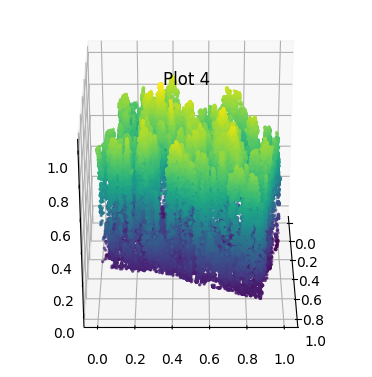

In [99]:
def plot_3d_cloud(df,i):
    #plot1 = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
    plot = df.loc[df["plot"] == i]
    plot = plot.drop(columns=['plot']).to_numpy()
    plot -= plot.min(axis=0, keepdims=True)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.scatter(
        *plot.swapaxes(0, 1),
        c=plot[:, 2],
        s=2,
    )

    ax.view_init(elev=30, azim=0)

    ax.set_title("Plot " + str (i), y=0.83)

    ax.set_aspect("equal")
plot_3d_cloud(lidardf,4)

# Filtering

In [ ]:
def load_and_filter(a,r,min_neigh):
    df = load_lidar()

    #Filter out lower a quantile, where the quantiles are computed plot per plot
    #Otherwise, if the ground level is not the same for each plot we remove
    #inequally between the different plots

    for i in df["plot"].unique():
        Q = df.loc[df["plot"] == i].quantile(a)                 #compute quantile of plot
        zQ = Q["z"]                                             #keep only height quantile
        df = df.loc[-((df["z"] < zQ) & (df["plot"] == i))]      #remove low points from selected plot

    #--------------
    iter = 0
    for i in df["plot"].unique():
        print("------------------------------------")
        df_i = df.loc[df["plot"] == i].copy()                   #extract selected plot
        KDT = scipy.spatial.KDTree(np.asarray(df_i))            #compute KDTree for later
        arr = df_i.drop(columns=['plot']).to_numpy()            #create array of (x,y,z) for iteration
        vals = []                                               #to store number of neighbours
        for point in arr:
            vals += [KDT.query_ball_point(np.append(point,1),r,workers = -1,return_length = True)]
        print(vals)
        del KDT
        #df_i["num_neigh"] = vals
        #if iter == 0:
        #    res = df_i
        #    df_i.head()
        #    iter += 1
        #else:
        #    res = pd.concat([res,df_i],ignore_index= True)
    #df = res

    #df = df.loc[df["num_neigh"] >= min_neigh].drop(columns =["num_neigh"])
    return(df)

lidardf = load_and_filter(0.2,0.05,100)

------------------------------------
[98, 139, 155, 182, 42, 255, 148, 192, 257, 614, 469, 549, 536, 89, 782, 734, 834, 686, 563, 576, 347, 648, 885, 1085, 875, 890, 743, 588, 622, 281, 967, 1018, 1142, 1110, 588, 807, 274, 264, 232, 1065, 1193, 1147, 1010, 954, 878, 470, 1223, 1106, 998, 849, 1172, 999, 841, 947, 795, 1104, 1077, 961, 743, 585, 950, 713, 417, 223, 242, 238, 41, 148, 937, 537, 466, 359, 475, 471, 422, 400, 175, 324, 305, 165, 321, 228, 372, 441, 888, 521, 524, 593, 550, 444, 249, 385, 369, 276, 296, 315, 147, 206, 268, 658, 633, 519, 476, 260, 286, 419, 520, 551, 609, 507, 974, 822, 419, 720, 438, 335, 482, 365, 504, 270, 792, 642, 901, 634, 208, 1177, 938, 788, 726, 129, 809, 708, 294, 785, 797, 818, 896, 957, 914, 991, 251, 1169, 1032, 443, 537, 164, 415, 807, 804, 393, 374, 800, 465, 1047, 1102, 1116, 1061, 1005, 850, 642, 477, 185, 122, 497, 779, 611, 302, 277, 224, 829, 536, 878, 815, 175, 134, 107, 63, 624, 768, 293, 684, 533, 333, 589, 669, 368, 159, 826, 141, 1

KeyboardInterrupt: 

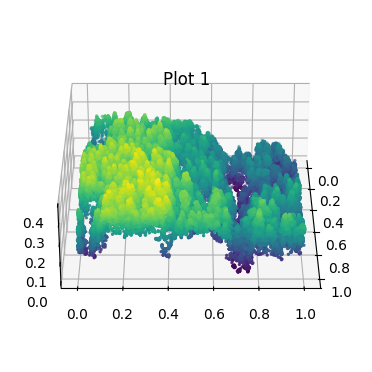

In [74]:
plot_3d_cloud(lidardf,1)
#lidardf.tail()